# ODE model for GAL switch in yeast
#### nicole pagane | 091918 | roberts lab

In [3]:
import scipy.integrate as snt
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
pass

/usr/local/lib/python2.7/dist-packages/scipy/__init__.py:111: UserWarning: Numpy 1.6.2 or above is recommended for this version of scipy (detected version 1.6.1)
  UserWarning)


In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## reactions and parameters
This is a simple model of the GAL switch in yeast.<br>
Terms to add/develop into model:<br>
<ul>
    <li>G2p (galactose transporter)</li>
    <li>G1p's functionality for signal transduction and only utilize it to metabolize galactose</li>
    <li>ES-complex formation to metabolize galactose and resultant high levels of G1p throughout</li>
    <li>kinetics of transcription and translation (assumed to be proportional to the effects of upstream regulation)</li>
    <li>RNA Polymerase II elongation rate on a GAL promoter driven gene = 2kb/min</li>
 </ul>


In [16]:
# reactions 
# gal + G3p -> G3p-gal (kgalon)
# G3p-gal -> gal + G3p (kgaloff)
# G3p-gal + G80p -> G3p-gal-G80p (kg80on)
# G3p-gal-G80p -> G3p-gal + G80p (kg80off)
# G80p + UASg -> G80p-UASg (kinon)
# G80p-UASg -> G80p + UASg (kinoff)
# G4p + UASg -> G4p-UASg (kacon)
# G4p-UASg -> G4p + UASg (kacoff)
# G4p-UASg -> G1p + G4p-UASg (kg1)
# G4p-UASg -> G3p + G4p-UASg (kg3)
# G4p-UASg -> G80p + G4p-UASg (kg80)
# G1p + gal -> G1p (kgalcat)

# rate constants
# these rates were taken from (Bianchi 2018)
kgalon = 1 
kgaloff = 1 
kg80on = 1 
kg80off = 1
kinon = 1
kinoff = 1
kacon = 1
kacoff = 1
kg1 = 1
kg3 = 1
kg80 = 1
kgalcat = 1 

# initial concentrations
gal0 = 1e-5
G1p0 = 0.25e-6 # assume to be the same as G3p0 for now
G3p0 = 0.25e-6
G4p0 = 0.005e-6
G80p0 = 0.05e-6
UASg0 = 0 # assume completely repressed
G3pGal0 = 0 
G3pGalG80p0 = 0
G80pUASg0 = 1e-7 # assume completely repressed
G4pUASg0 = 0 # assume completely repressed

# reactions 
# gal + G3p -> G3p-gal (kgalon)
# G3p-gal -> gal + G3p (kgaloff)
# G3p-gal + G80p -> G3p-gal-G80p (kg80on)
# G3p-gal-G80p -> G3p-gal + G80p (kg80off)
# G80p + UASg -> G80p-UASg (kinon)
# G80p-UASg -> G80p + UASg (kinoff)
# G4p + UASg -> G4p-UASg (kacon)
# G4p-UASg -> G4p + UASg (kacoff)
# G4p-UASg -> G1p + G4p-UASg (kg1)
# G4p-UASg -> G3p + G4p-UASg (kg3)
# G4p-UASg -> G80p + G4p-UASg (kg80)
# G1p + gal -> G1p (kgalcat)


# species conservation
# UASg = G80p-UASg0 - G80p-UASg - G4p-UASg 

# define reaction rates function
#where spec[0] = gal, spec[1] = G1p, spec[2] = G3p, spec[3] = G4p
#      spec[4] = G80p, spec[5] = G3p-gal, spec[6] = G3p-gal-G80p,
#      spec[7] = G80p-UASg, spec[8] = G4p-UASg
def rates(spec, t):
    return np.asarray([
        -kgalon*spec[0]*spec[2] + kgaloff*spec[5] - kgalcat*spec[1]*spec[0], # dgal/dt
        kg1*spec[8], # dG1p/dt
        -kgalon*spec[0]*spec[1] + kgaloff*spec[5] + kg3*spec[8], # dG3p/dt
        -kacon*spec[3]*(G80pUASg0 - spec[7] - spec[8]) + kacoff*spec[8], # dG4p/dt
        -kg80on*spec[5]*spec[4] + kg80off*spec[6] - kinon*spec[5]*(G80pUASg0 - spec[7] - spec[8]) + kinoff*spec[7] + kg80*spec[8], # dG80p/dt
        kgalon*spec[0]*spec[1] - kgaloff*spec[5] - kg80on*spec[5]*spec[4] + kg80off*spec[6], # dG3pGal/dt
        kg80on*spec[4]*spec[5] - kg80off*spec[6], # dG3pGalG80/dt
        kinon*spec[5]*(G80pUASg0 - spec[7] - spec[8]) - kinoff*spec[7], # G80pUASg/dt
        kacon*spec[3]*(G80pUASg0 - spec[7] - spec[8]) - kacoff*spec[8]# G4pUASg/dt
    ])


In [19]:
fig = plt.figure(figsize = (40,10))

# solve the DE numerically
t = np.linspace(0,100, 1000)
spec0 = (gal0, G1p0, G3p0, G4p0, G80p0, G3pGal0, G3pGalG80p0,G80pUASg0,G4pUASg0)
ode = snt.odeint(rates, spec0, t, hmax=1e-5)

# plot the numerical solution
specs = ['gal', 'G1p', 'G3p', 'G4p', 'G80p', 'G3p-gal', 'G3p-gal-G80p', 'G80p-UASg', 'G4p-UASg']
#plot ligand 
for i in range(np.shape(ode)[1]):
    ax = fig.add_subplot(2,np.shape(ode)[1] + 1, i + 1)
    ax.plot(t, ode[:, i], linewidth = 4)
    ax.set_title(specs[i])
    ax.set_ylabel('[' + specs[i] + '] (M)')
    ax.set_xlabel('time (s)')

plt.show()

In [22]:
# reaction rate dependence on susbstrate concentration simulations
Srange = np.linspace(S0/10, S0*500, 50)
data2 = {}
for i in range(len(Srange)):
    spec0 = (Srange[i], ES0, P0, ESS0)
    ode = snt.odeint(rates, spec0, t, hmax=1e-5)
    data2[Srange[i]] = ode
print 'done'

done


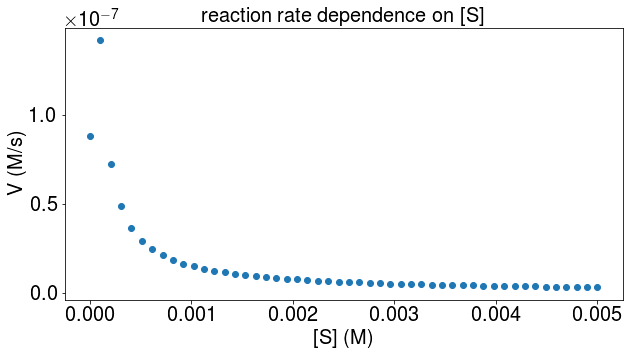

In [23]:
fig = plt.figure(figsize=(10,5))
# plot the data

S = []
V = []
for i in data2:
    dP = np.diff(data2[i][:,2])
    dt = np.diff(t)
    dPdt = np.mean(dP/dt)
    S.append(i)
    V.append(dPdt)

plt.plot(S, V, 'o')
plt.xlabel('[S] (M)')
plt.ylabel('V (M/s)')
plt.title('reaction rate dependence on [S]')

plt.show()